<a href="https://colab.research.google.com/github/Mogreine29/HandsOnAI_2/blob/main/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import gensim
from keras.optimizers import Adam
from keras_preprocessing import text, sequence
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
import pickle
import re
import string
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Mounting google drive to access data and save models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My\ Drive/Challenge2

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1aIAK0Qi-pofkSLi3xijkAex-JrSW_tn8/Challenge2


Reading data 

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/Challenge2/fake_train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Challenge2/fake_test.csv')

Removing useless columns

In [ ]:
df_train = df_train.drop(['Unnamed: 0', 'target_name'], axis = 1)
df_test = df_test.drop(['Unnamed: 0', 'target_name'], axis = 1)

Deleting parasite data (see report for more info)

In [ ]:
df_train.drop([1136, 1180, 1317, 1362, 1429], inplace = True )

Adding new data

In [ ]:
df_real = pd.read_csv("real_news.csv")
df_fake = pd.read_csv("fake_news.csv")
df_real = df_real.drop(['site', 'url', 'title'], axis = 1)
df_fake = df_fake.drop(['site', 'url', 'title'], axis = 1)
df_real['label'] = 0
df_fake['label'] = 1
df_real.rename(columns = {'text':'data'}, inplace = True)
df_fake.rename(columns = {'text':'data'}, inplace = True)
df_train = df_train.append(df_real, ignore_index = True)
df_train = df_train.append(df_fake, ignore_index = True)

df_train['data'] = df_train['data'].astype(str)
df_test['data'] = df_test['data'].astype(str)

Removing Stopwords and other characters using RegEx

In [ ]:
STOPWORDS = set(stopwords.words('french'))
moreStopwords = ['plus', 'comme', 'a', 'il', 'alors','au',
'aucuns','aussi','autre','avant','avec','avoir','bon','car','ce','cela','ces','ceux','chaque','ci',
'comme','comment','dans','des','du','dedans','dehors','depuis','devrait','doit','donc','dos','début',
'elle','elles','en','encore','essai','est','et','eu','fait','faites','fois','font','hors','ici','il',
'ils','je',	'juste','la','le','les','leur','là','ma','maintenant','mais','mes','mien','moins','mon',
'mot','même','ni','nommés','notre','nous','ou','où','par','parce','pas','peut','peu','plupart','pour',
'pourquoi','quand','que','quel','quelle','quelles','quels','qui','sa','sans','ses','seulement','si',
'sien','son','sont','sous','soyez',	'sujet','sur','ta','tandis','tellement','tels','tes','ton','tous',
'tout','trop','très','tu','voient','vont','votre','vous','vu','ça','étaient','état','étions','été','être',
'cette','celle','dont','celui', 'adsbygoogle','window','secretnews','leurs','ainsi','toute','déjà','autres',
'suivre','facebook','twitter','parodique', 'média','collaboratif', 'libre','notamment',
'mercilesentreprisesgiletsjaunes',
'entreprisesgiletsjaunes',
'dontforgetyourmariage']

STOPWORDS.update(moreStopwords)
def cleaner(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)

    text = ' '.join(word for word in text.split() if word not in STOPWORDS)   
    return text

In [ ]:
df_train['data'] = df_train['data'].apply(cleaner)
df_test['data'] = df_test['data'].apply(cleaner)

In [ ]:
df_train = df_train.append(df_test, ignore_index=True)
shuffled = df_train.sample(frac=1).reset_index()

In [ ]:
x, x_test, y, y_test = train_test_split(shuffled.data,shuffled.label,test_size=0.2,train_size=0.8)
x_train, x_val, y_train, y_val = train_test_split(x,y,test_size = 0.25,train_size =0.75)

Text vectorization using Keras

In [ ]:
max_features = 10000
maxlen = 512

In [ ]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [ ]:
tokenized_val = tokenizer.texts_to_sequences(x_val)
X_val = sequence.pad_sequences(tokenized_val, maxlen=maxlen)

tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

Embedding Matrix for our model

In [ ]:
#!wget https://embeddings.net/embeddings/frWac_non_lem_no_postag_no_phrase_200_cbow_cut100.bin

In [ ]:
word2vec_model_fr = gensim.models.KeyedVectors.load_word2vec_format("frWac_non_lem_no_postag_no_phrase_200_cbow_cut100.bin",binary=True)

In [ ]:
embeddings_index = dict((key,word2vec_model_fr[key]) for key in word2vec_model_fr.vocab.keys())

In [ ]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


Parameters of the Deep learning model

In [ ]:
batch_size = 256
epochs = 20
embed_size = 200

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

Model architecture

In [ ]:
#Defining Neural Network
model = Sequential()

#Non-trainable embeddidng layer 
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))

#LSTM 
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(learning_rate = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.build()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 512, 200)          2000000   
                                                                 
 lstm (LSTM)                 (None, 512, 128)          168448    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,219,969
Trainable params: 219,969
Non-trainable params: 2,000,000
_________________________________________________________________


model.fit()

In [ ]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_val,y_val) , epochs = epochs , callbacks = [learning_rate_reduction])

Epoch 1/20
50/50 [==============================] - 231s 4s/step - loss: 0.3866 - accuracy: 0.8133 - val_loss: 0.2585 - val_accuracy: 0.8843 - lr: 0.0100
Epoch 2/20
50/50 [==============================] - 225s 5s/step - loss: 0.2242 - accuracy: 0.9130 - val_loss: 0.1752 - val_accuracy: 0.9409 - lr: 0.0100
Epoch 3/20
50/50 [==============================] - 222s 4s/step - loss: 0.1617 - accuracy: 0.9386 - val_loss: 0.1566 - val_accuracy: 0.9435 - lr: 0.0100
Epoch 4/20
50/50 [==============================] - 223s 4s/step - loss: 0.1382 - accuracy: 0.9500 - val_loss: 0.1700 - val_accuracy: 0.9355 - lr: 0.0100
Epoch 5/20
50/50 [==============================] - ETA: 0s - loss: 0.1276 - accuracy: 0.9526
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
50/50 [==============================] - 223s 4s/step - loss: 0.1276 - accuracy: 0.9526 - val_loss: 0.1560 - val_accuracy: 0.9431 - lr: 0.0100
Epoch 6/20
50/50 [==============================] - 220s 4s/step - loss:

Accuracy test after training

In [ ]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Validating Data is - " , model.evaluate(X_val,y_val)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

396/396 [==============================] - 105s 264ms/step - loss: 0.0061 - accuracy: 0.9985
Accuracy of the model on Training Data is -  99.84977841377258 %
132/132 [==============================] - 33s 254ms/step - loss: 0.2203 - accuracy: 0.9492
Accuracy of the model on Validating Data is -  94.92409825325012 %
132/132 [==============================] - 34s 254ms/step - loss: 0.2107 - accuracy: 0.9502
Accuracy of the model on Testing Data is -  95.01897692680359 %


Saving model to google drive for further use

In [ ]:
path_to_save = '/content/drive/MyDrive/Challenge2/model20.h5'

In [ ]:
model.save(path_to_save)

In [ ]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

Graphic of model training


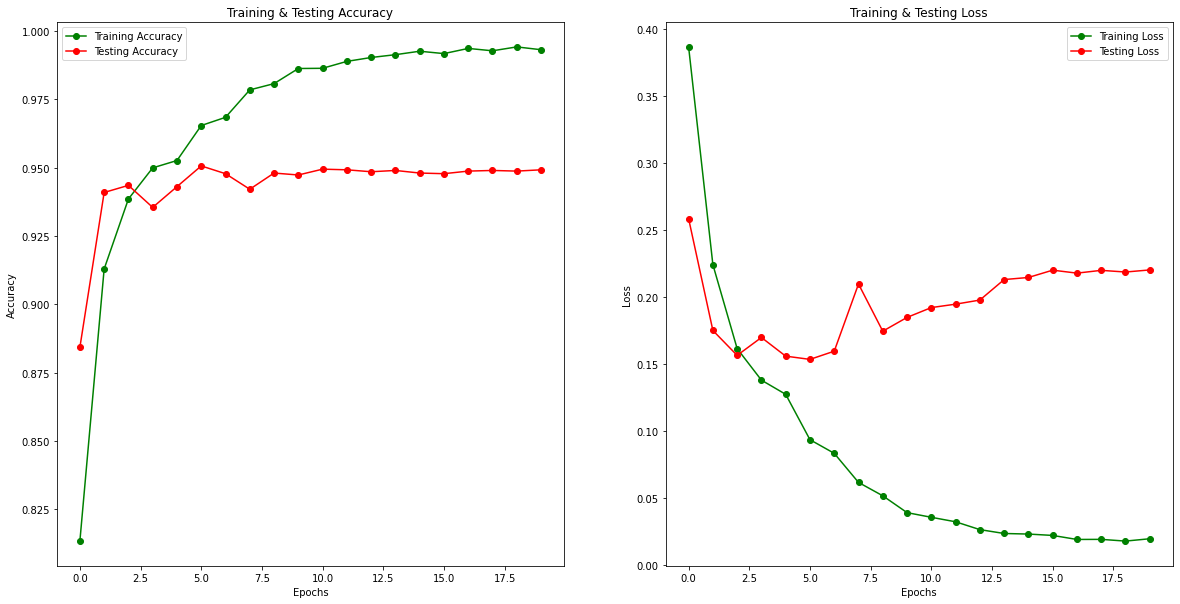

In [ ]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

Prediction on some data

In [ ]:
pred = model.predict(X_test)

132/132 [==============================] - 34s 253ms/step


Confusion matrix

In [ ]:
print(classification_report(list(y_test), np.round(pred).astype(int), target_names = ['Not Fake','Fake']))

              precision    recall  f1-score   support

    Not Fake       0.96      0.95      0.96      2554
        Fake       0.93      0.94      0.94      1662

    accuracy                           0.95      4216
   macro avg       0.95      0.95      0.95      4216
weighted avg       0.95      0.95      0.95      4216



In [ ]:
cm = confusion_matrix(y_test,np.round(pred).astype(int))
cm

array([[2437,  117],
       [  93, 1569]])

In [ ]:
cm = pd.DataFrame(cm , index = ['Fake','Original'] , columns = ['Fake','Original'])

Text(69.0, 0.5, 'Actual')

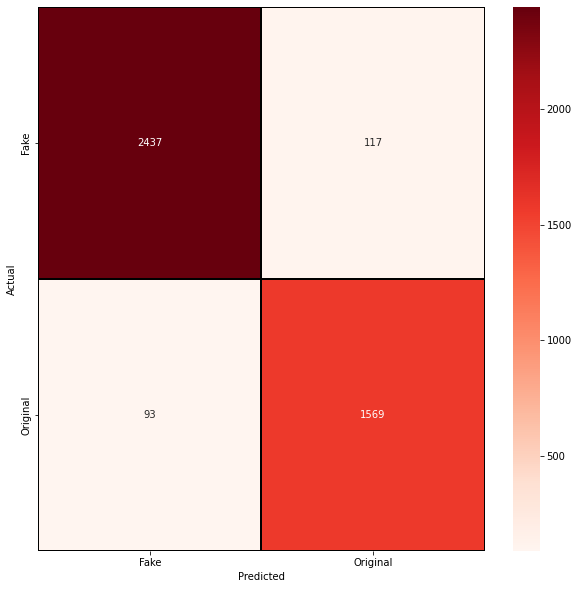

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Reds", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Original'] , yticklabels = ['Fake','Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")